In [1]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.prediction_models.scorer import moving_average_score
from src.prediction_models.moving_average import MovingAverage

In [2]:
ts = joblib.load('../../bld/out/data_processed/BTC_POT.p.lzma')

In [3]:
# Restriction to chart data only
ts = ts[ts.CHART == True].dropna(axis=1).drop(['CHART', 'TRADE'], axis=1)

# Moving averages

Here, I will be demonstrating a moving average crossover strategy. We will use two moving averages, one we consider *fast*, and the other *slow*. The strategy is:

Trade the asset when the fast moving average crosses over the slow moving average.
Exit the trade when the fast moving average crosses over the slow moving average again.

The fast version is a 20-day moving average and the slow one a 50-day moving average.

C:\Users\tobia\git\crypto\src\prediction_models\moving_average.py:58: RuntimeWarning: invalid value encountered in greater
  self.regimes = np.where(self.ma_fast - self.ma_slow > 0, 1, 0)


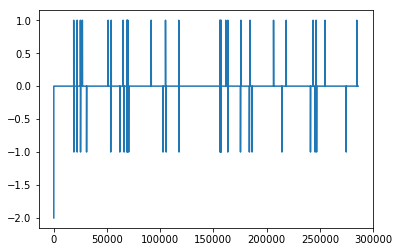

-1.26709680188


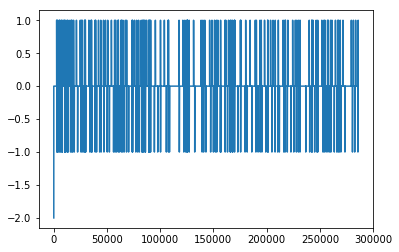

-8.38140319907


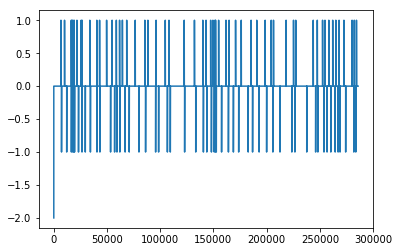

-1.99612033076


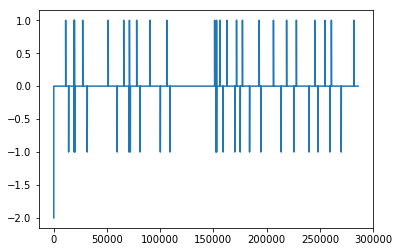

-1.13740046981


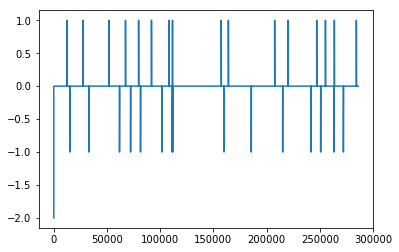

-0.982727178123


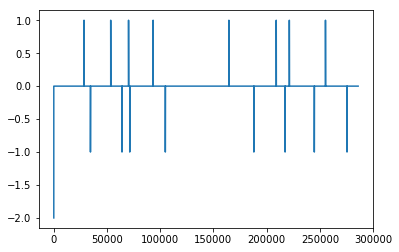

-0.223131893919


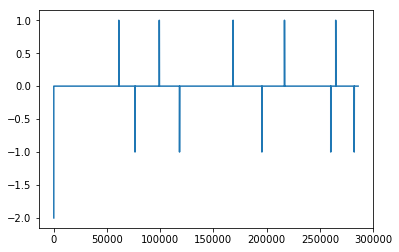

-0.0954245950049


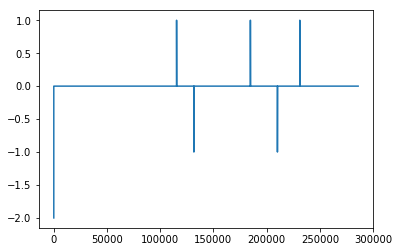

-0.937221920781


In [4]:
for fast, slow in [[1, 50], [2, 5], [5, 10], [10, 20], [15, 30], [20, 50], [50, 100], [100, 200]]:
    # Correction to days
    fast *= 12 * 24
    slow *= 12 * 24
    ma = MovingAverage()
    ma = ma.fit(ts.BTC_POT_CLOSE, window_fast=fast, window_slow=slow)
    plt.plot(ma.signals)
    plt.show()
    plt.close()
    results = ma.predict()
    print(moving_average_score(ts.BTC_POT_CLOSE, results))

# Test MovingAverage

In [5]:
from src.prediction_models.moving_average import MovingAverage

In [6]:
check_estimator(MovingAverage)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()